# Литература и ссылки (intro)

#### Этот блокнот основан на посте:
https://github.com/msurtsukov/ae_vae_gan/blob/master/autoencoders_1.ipynb  
Можно сказать что это репост кода + некая творческай постобработка.

Схемы нейронок визуализировал через Netron (https://netron.app/)  


#### Литература и ссылки из поста:
Первая часть поста создателя *Keras* *Francois Chollet* про автоэнкодеры в Keras (создание автоэнкодеров):  
https://blog.keras.io/building-autoencoders-in-keras.html  

А так же главы про автоэнкодеры в *Deep Learning Book* (общая теория):  
http://www.deeplearningbook.org/contents/autoencoders.html


# Автоэнкодеры

***Автоэнкодеры*** - это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой *код* описывающий модель. *Автоэнкодеры* конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе. Обычно их ограничивают в размерности *кода* (он меньше, чем размерность сигнала) или штрафуют за активации в *коде*. Входной сигнал восстанавливается с ошибками из-за потерь при кодировании, но чтобы их минимизировать, сеть вынуждена учиться отбирать наиболее важные признаки.

То есть *автоэнкодеры* состоят из двух частей: энкодера $g$ и декодера $f$. Энкодер переводит входной сигнал в его представление (*код*): $h = g(x)$ , а декодер, как не трудно догадаться, восстанавливает сигнал по его *коду*:  $x=f(h)$.

Автоэнкодер изменяя $f$ и $g$ стремится выучить тождественную функцию $x = f(g(x))$ минимизируя какой-то функционал ошибки

$$ L(x, f(g(x))). $$

При этом семейства функций энкодера $g$ и декодера $f$ как-то ограничены, чтобы автоэнкодер был вынужден отбирать наиболее важные свойства сигнала.

![](pics/01_autoencoders_ae_schema.png)

Сама по себе способность автоэнкодеров сжимать данные используется редко, так как обычно они работают хуже, чем вручную написанные алгоритмы для конкретных типов данных вроде звуков или изображений. А также для них критически важно, чтобы данные принадлежали той генеральной совокупности, на которой сеть обучалась. Обучив автоэнкодер на цифрах, его нельзя применять для кодирования чето-то другого (например, человеческих лиц).

Однако автоэнкодеры можно использовать для предобучения, например, когда стоит задача классификации, а размеченных пар слишком мало. Или для понижения размерности в данных для последующей визуализации. Либо когда просто надо научиться различать полезные свойства входного сигнала.

Более того некоторые их развития (о которых тоже будет написано далее), такие как вариационный автоэнкодер (*VAE*), а также его сочетание с состязающимися генеративным сетями (*GAN*) дают очень интересные результаты и находятся сейчас на переднем крае науки о генеративных моделях.

### Keras

***Keras*** - это очень удобная высокоуровненая библиотека для глубокого обучения, работающая поверх *tensorflow*. В ее основе лежат слои, соединяя которые между собой получаем модели. Созданные однажды модели и слои сохраняют в себе свои внутренние параметры, и потому, например, можно обучить слой в одной модели, а использовать его уже в другой, что очень удобно. 

Модели *keras* легко сохранять/загружать, процесс их обучения прост, но в то же время глубоко настраиваемый, они также свободно встраиваются в *tensorflow* код (как операции над тензорами).

В качестве некоторой аналогии можно сказать, что *tensorflow* - аналог *numpy*, а *keras* - аналог *scikit-learn*.

В качестве данных будем использовать датасет рукописных цифр ***MNIST***

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime

import numpy as np  
import tensorflow as tf
import matplotlib.pyplot as plt

import keras.backend as K
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.regularizers import L1L2

from visualization.plot_graph import plot_digits, plot_digits_page
from data.get_data import get_mnist

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


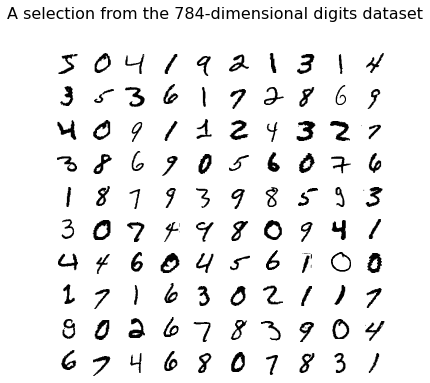

In [11]:
# В качестве данных будем использовать датасет рукописных цифр ***MNIST***

# Load MNIST
x_train, y_train, x_test, y_test = get_mnist()

for i in [x_train, y_train, x_test, y_test]:
    print (i.shape)

plot_digits_page(x_train)

## Сжимающий автоэнкодер

Для начала создадим наиболее простой (сжимающий, undercomplete) автоэнкодер с *кодом* малой размерности из двух полносвязных слоев: енкодера и декодера.
Так как интенсивность цвета нормировали на единицу, то активацию выходного слоя возьмем сигмоидой.

Создадим отдельные модели для энкодера, декодера и целого автоэнкодера. Для этого создаются экземпляры слоев и применяются один за другим. В конце все объединяется в модели.


Схема, от руки  
<img src="pics/01_autoencoders_autoencoder_0.png" width="300" />

Схема через Netron (https://netron.app/)  
![](pics/01_autoencoders_autoedcoder_0.png)

In [9]:
def create_dense_ae():  
    # Размерность кодированного представления  
    encoding_dim = 49  
  
    # Энкодер  
    # Входной плейсхолдер  
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности  
    # Вспомогательный слой решейпинга  
    flat_img = Flatten()(input_img)  
    # Кодированное полносвязным слоем представление  
    encoded = Dense(encoding_dim, activation='relu')(flat_img)  
      
    # Декодер  
    # Раскодированное другим полносвязным слоем изображение  
    input_encoded = Input(shape=(encoding_dim,))  
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded)  
    decoded = Reshape((28, 28, 1))(flat_decoded)  
  
    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои  
    # Другие модели можно так же использовать как и слои  
    encoder = Model(input_img, encoded, name="encoder")  
    decoder = Model(input_encoded, decoded, name="decoder")  
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")  
    return encoder, decoder, autoencoder  

# Создадим и скомпилируем модель (под компиляцией в данном случае понимается 
# построение графа вычислений обратного распространения ошибки)

encoder, decoder, autoencoder = create_dense_ae()  
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',run_eagerly=False)  

# Сохраним в формате h5
autoencoder.save("./models/01_autoencoders_encoder_01.h5", save_format="h5")

# Посмотрим на число параметров
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 49)                38465     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         39200     
                                                                 
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time

# For tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Обучим теперь наш автоэнкодер
autoencoder.fit(x_train, x_train,  
                epochs=50,  
                batch_size=256,  
                shuffle=True,  
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
                )

Epoch 1/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2571 - val_loss: 0.1750
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1551 - val_loss: 0.1369
...
Epoch 49/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0785 - val_loss: 0.0778
Epoch 50/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0785 - val_loss: 0.0778
Wall time: 1min 5s


1/1 [==============================] - 0s 46ms/step
[ 8.069133   6.9735146  6.2105474  5.493402   5.956487   6.1830635
  7.636796   5.9698296  3.6566653  8.447571   5.1186934  4.370529
  5.6363254  3.5949817  5.5122924  6.8837748  4.7383356  8.43859
 10.872069   6.36263    2.970511   6.15179    8.824714   1.8481348
  4.362949   8.770811   2.483526   5.348289   5.7401023  0.8172023
  4.9552426  5.3553886  7.3902864  2.4176683  1.4049736  4.8096175
  5.123876   5.8863826  5.9261246  8.6967945  8.440994  13.528978
  4.1368613 13.791303   6.220251   5.674836   8.286977   5.567984
  1.7695613]
1/1 [==============================] - 0s 40ms/step


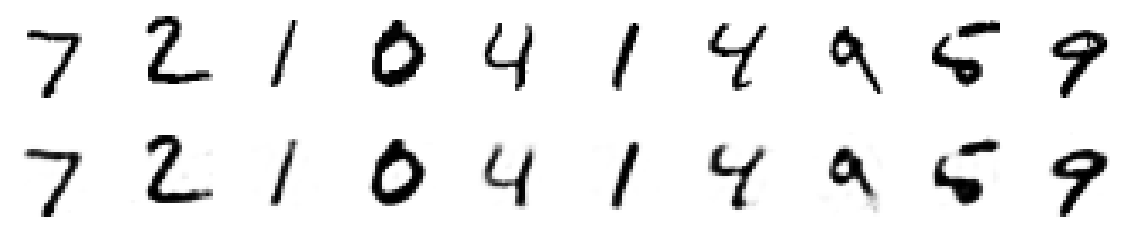

In [16]:
# Закодируем несколько изображений и, ради интереса, взглянем на пример кода
# Декодируем эти коды и сравним с оригиналами
# ----------------------------------------------------
n = 10
imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
print(encoded_imgs[0])

decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)
plot_digits(imgs, decoded_imgs)

 ## Глубокий автоэнкодер

Никто не мешает нам сделать такой же автоэнкодер, но с большим числом слоев. В таком случае он сможет вычлинять более сложные нелинейные закономерности

**Общая схема**  
![](pics/01_autoencoders_d_autoencoder_0.png)

**Encoder**  
![](pics/01_autoencoders_d_autoencoder_1.png)

**Decoder**  
![](pics/01_autoencoders_d_autoencoder_2.png)

In [10]:
def create_deep_dense_ae():  
    # Размерность кодированного представления  
    encoding_dim = 49  
  
    # Энкодер  
    input_img = Input(shape=(28, 28, 1))  
    flat_img = Flatten()(input_img)  
    x = Dense(encoding_dim*3, activation='relu')(flat_img)  
    x = Dense(encoding_dim*2, activation='relu')(x)  
    encoded = Dense(encoding_dim, activation='linear')(x)  
      
    # Декодер  
    input_encoded = Input(shape=(encoding_dim,))  
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)  
    x = Dense(encoding_dim*3, activation='relu')(x)  
    flat_decoded = Dense(28*28, activation='sigmoid')(x)  
    decoded = Reshape((28, 28, 1))(flat_decoded)  
      
    # Модели  
    encoder = Model(input_img, encoded, name="encoder")  
    decoder = Model(input_encoded, decoded, name="decoder")  
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")  
    return encoder, decoder, autoencoder  
  
d_encoder, d_decoder, d_autoencoder = create_deep_dense_ae()  
d_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  

# Сохраним в формате h5
d_autoencoder.save("./models/01_autoencoders_d_autoencoder_01.h5", save_format="h5")


d_autoencoder.summary()
# Число параметров выросло более чем в 3 раза

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 49)                134750    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         135485    
                                                                 
Total params: 270,235
Trainable params: 270,235
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%time

# For tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

d_autoencoder.fit(x_train, x_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test),
                  callbacks=[tensorboard_callback]
                  )  

Epoch 1/100
235/235 [==============================] - 3s 10ms/step - loss: 0.2197 - val_loss: 0.1470
Epoch 2/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1328 - val_loss: 0.1204
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1149 - val_loss: 0.1085
...
Epoch 99/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0725 - val_loss: 0.0724
Epoch 100/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0725 - val_loss: 0.0725
Wall time: 2min 54s


1/1 [==============================] - 0s 52ms/step
[ -8.855019     1.5110927   -0.13381006  -1.4702172   -1.8845927
  -0.38132343  -4.5271854   -4.45621      0.74549174  -0.06293422
  -2.383507     1.4185835    0.02854872  -5.8665967   -2.9132328
  -0.21498895  -0.25342086  -1.1272484   -3.876206    -5.364826
   1.9106107    2.0689783   -4.0865707    3.1190162    5.8041577
  -4.5663967    4.9877644    5.2779975    5.418219     3.4577665
  -0.7322398   -1.9366341    6.5912066   -2.2484288    2.9481392
   0.8309816   -4.6536613   -1.8207083    4.683738    -4.2983165
  -2.022669    -5.1044936   -3.125471   -10.503105     1.0265526
   0.74734765  -9.096932     0.97299844  -5.340494  ]
1/1 [==============================] - 0s 59ms/step


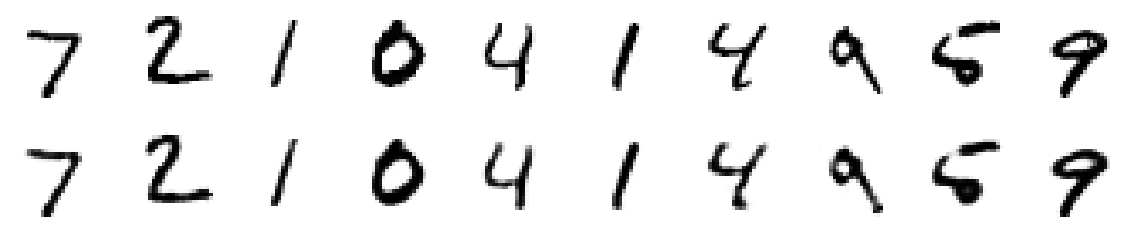

In [13]:
n = 10
imgs = x_test[:n]
encoded_imgs = d_encoder.predict(imgs, batch_size=n)
print(encoded_imgs[0])

decoded_imgs = d_decoder.predict(encoded_imgs, batch_size=n)
plot_digits(imgs, decoded_imgs)

Число параметров выросло более чем в 3 раза. Обучение прошло где-то в 2 раза медленнее.
Но и результат оказался немного лучше.

## Сверточный автоэнкодер

Так как мы работаем с картинками, в данных должна присутствовать некоторая пространственная инвариантность, попробуем этим воспользоваться: построим *сверточный автоэнкодер*  

**Общая схема**  
![](pics/01_autoencoders_c_autoencoder_0.png)

**Encoder**  
![](pics/01_autoencoders_c_autoencoder_1.png)

**Decoder**  
![](pics/01_autoencoders_c_autoencoder_2.png)

In [13]:
def create_deep_conv_ae():  
    input_img = Input(shape=(28, 28, 1))  
  
    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)  
    x = MaxPooling2D((2, 2), padding='same')(x)  
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)  
    x = MaxPooling2D((2, 2), padding='same')(x)  
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)  
  
    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное  
  
    input_encoded = Input(shape=(7, 7, 1))  
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)  
    x = UpSampling2D((2, 2))(x)  
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)  
    x = UpSampling2D((2, 2))(x)  
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)  
  
    # Модели  
    encoder = Model(input_img, encoded, name="encoder")  
    decoder = Model(input_encoded, decoded, name="decoder")  
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")  
    return encoder, decoder, autoencoder  
  
c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()  
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  

# Сохраним в формате h5
c_autoencoder.save("./models/01_autoencoders_c_autoencoder.h5", save_format="h5")

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 1)           24385     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         24385     
                                                                 
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time

# For tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

c_autoencoder.fit(x_train, x_train,  
                epochs=64,  
                batch_size=256,  
                shuffle=True,  
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
                )

Epoch 1/64
235/235 [==============================] - 22s 81ms/step - loss: 0.1752 - val_loss: 0.1011
Epoch 2/64
235/235 [==============================] - 18s 79ms/step - loss: 0.0948 - val_loss: 0.0882
Epoch 3/64
235/235 [==============================] - 18s 78ms/step - loss: 0.0873 - val_loss: 0.0836
...
Epoch 62/64
235/235 [==============================] - 19s 80ms/step - loss: 0.0696 - val_loss: 0.0689
Epoch 63/64
235/235 [==============================] - 19s 80ms/step - loss: 0.0696 - val_loss: 0.0695
Epoch 64/64
235/235 [==============================] - 19s 80ms/step - loss: 0.0696 - val_loss: 0.0690
Wall time: 20min


1/1 [==============================] - 0s 94ms/step


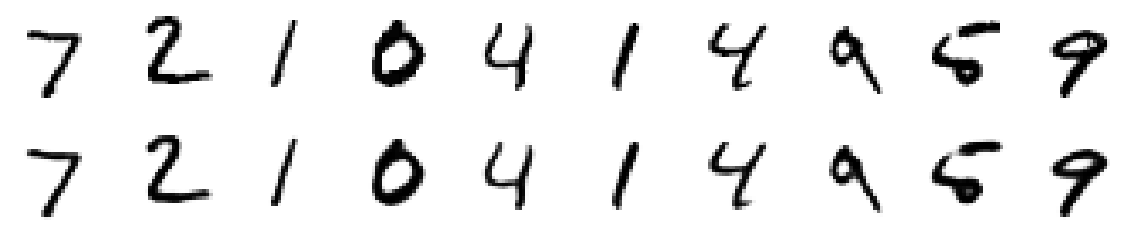

In [9]:
n = 10  

imgs = x_test[:n]  
encoded_imgs = c_encoder.predict(imgs, batch_size=n)  
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)  
  
plot_digits(imgs, decoded_imgs)

Не смотря на то, что количество параметров у этой сети намного меньше чем у полносвязных сетей, функция ошибки насыщается на значительно меньшей величине.  
Но, т.к. сетка становится сложнее, то и ее обучение идет намного дольше, хоть и на GPU.  

PS: На TPU в Google Colab идет в разы шустрее, чем на моей старой GPU.

## Denoising автоэнкодер

Автоэнкодеры можно обучить убирать шум из данных: для этого просто передаем на вход зашумленные данные и сравниваем на выходе с данными без шума:

$$ L(x, f(g(\hat x))), $$
где $\hat x$ - зашумленные данные.

В *Keras* можно оборачивать произвольные операции из нижележащего фреймворка в Lambda слой. Обращаться к операциям из *tensorflow* можно через модуль *backend*

Создадим модель которая будет зашумлять входное изображение, а избавлять от шума переобучим какой-либо из уже созданных автоэнкодеров

**Общая схема**  
![](pics/01_autoencoders_denoiser_model_0.png)

**Как выглядит Lamda слой** (особо ничего не понятно :) )  
![](pics/01_autoencoders_denoiser_model_1.png)

**Autoencoder** - не показываю, т.к. была использована архитектура, такая же как в прошлой модели. Там все то же самое  

In [14]:
# Создадим модель которая будет зашумлять входное изображение, 
# а избавлять от шума переобучим какой-либо из уже созданных автоэнкодеров

batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(c_autoencoder)
# noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

# Сохраним в формате h5
denoiser_model.save("./models/01_autoencoders_denoiser_model.h5", save_format="h5")

denoiser_model.summary()

Model: "denoiser"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(16, 28, 28, 1)]         0         
                                                                 
 noiser (Functional)         (16, 28, 28, 1)           0         
                                                                 
 autoencoder (Functional)    (None, 28, 28, 1)         48770     
                                                                 
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time

# For tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


denoiser_model.fit(x_train, x_train,
                   epochs=50,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test),
                   callbacks=[tensorboard_callback]
                   )

Epoch 1/50
3750/3750 [==============================] - 42s 11ms/step - loss: 0.1240 - val_loss: 0.1152
Epoch 2/50
3750/3750 [==============================] - 40s 11ms/step - loss: 0.1104 - val_loss: 0.1084
Epoch 3/50
3750/3750 [==============================] - 39s 10ms/step - loss: 0.1076 - val_loss: 0.1053
...
Epoch 48/50
3750/3750 [==============================] - 39s 10ms/step - loss: 0.1014 - val_loss: 0.1006
Epoch 49/50
3750/3750 [==============================] - 38s 10ms/step - loss: 0.1014 - val_loss: 0.1008
Epoch 50/50
3750/3750 [==============================] - 37s 10ms/step - loss: 0.1013 - val_loss: 0.1015
Wall time: 33min 16s


1/1 [==============================] - 0s 15ms/step


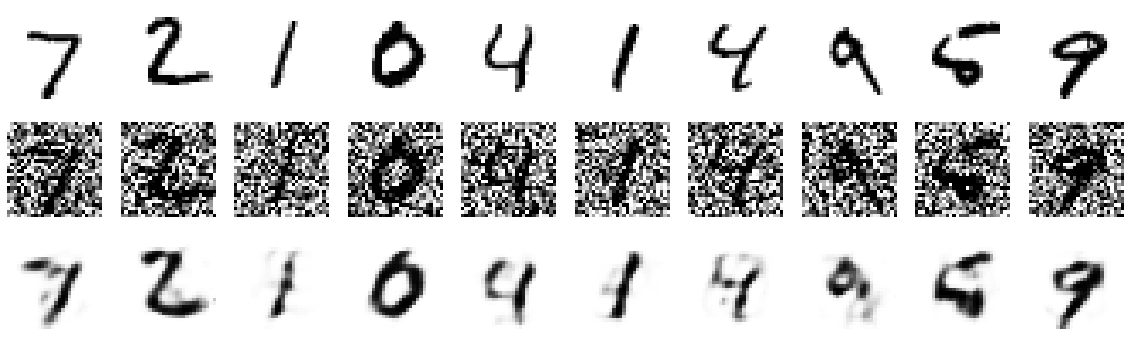

In [23]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

Цифры на зашумленных изображениях с трудом проглядываются, однако *denoising autoencoder* неплохо убрал шум и цифры стали вполне читаемыми

## Разреженный (Sparse) автоэнкодер

Разреженный автоэнкодер - это просто автоэнкодер, у которого в функцию потерь добавлен штраф за величины значений в *коде*, то есть автоэнкодер стремится минимизировать такую функцию ошибки:
$$ L(x, f(g(x))) + \Omega(h), $$
где $h = g(x)$ - код,

$\Omega(h)$ - обычный регуляризатор (например L1):
$$\Omega(h) = \lambda * |h|$$

Разреженный автоэнкодер не обязательно сужается к центру. Его *код* может иметь и большую размерность, чем входной сигнал. Обучаясь приближать тождественную функцию $x = f(g(x))$ он учится в *коде* выделять полезные свойства сигнала. Из-за регуляризатора даже расширяющийся к центру разреженный автоэнкодер не может выучить тождественную функцию напрямую.

**Общая схема** - использовался в качестве базы глубокий автоэнкодер.  
Кол-во слоев небольшое, но размерности теперь меньше: 784 -> 48 -> 32 -> 16. И слой кодирования - всего 16 нейронов.       
![](pics/01_autoencoders_s_autoencoder_0.png)

**Encoder**  
![](pics/01_autoencoders_s_autoencoder_1.png)

**Decoder**  
![](pics/01_autoencoders_s_autoencoder_2.png)

In [16]:
def create_sparse_ae():
    encoding_dim = 16
    lambda_l1 = 0.00001
    
    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
s_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Сохраним в формате h5
s_autoencoder.save("./models/01_autoencoders_s_autoencoder.h5", save_format="h5")

s_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                39776     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         40544     
                                                                 
Total params: 80,320
Trainable params: 80,320
Non-trainable params: 0
_________________________________________________________________


In [4]:
%%time

# For tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

s_autoencoder.fit(x_train, x_train,
                epochs=15000,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
                )

Epoch 1/15000
235/235 [==============================] - 6s 13ms/step - loss: 0.2884 - val_loss: 0.2131
Epoch 2/15000
235/235 [==============================] - 2s 9ms/step - loss: 0.1887 - val_loss: 0.1719
Epoch 3/15000
235/235 [==============================] - 2s 8ms/step - loss: 0.1653 - val_loss: 0.1565
Epoch 4/15000
235/235 [==============================] - 2s 9ms/step - loss: 0.1517 - val_loss: 0.1452
Epoch 5/15000
...
Epoch 14998/15000
235/235 [==============================] - 2s 8ms/step - loss: 0.0967 - val_loss: 0.0969
Epoch 14999/15000
235/235 [==============================] - 2s 8ms/step - loss: 0.0967 - val_loss: 0.0968
Epoch 15000/15000
235/235 [==============================] - 2s 10ms/step - loss: 0.0967 - val_loss: 0.0966
Wall time: 8h 5min 33s


1/1 [==============================] - 0s 106ms/step
[-0.9996099  -0.09432303 -0.9424433  -0.28984058  0.25380987  0.08187616
 -0.10946465  1.9169918  -0.05616117 -0.35208678 -0.48287174  0.30397856
  0.29545426 -0.49761432 -0.873715   -1.9202902 ]
1/1 [==============================] - 0s 83ms/step


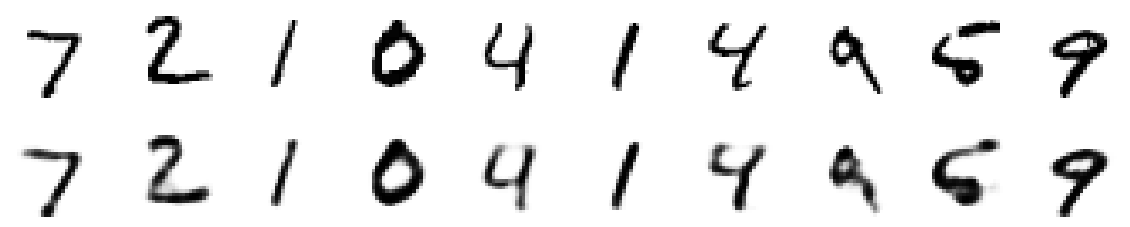

In [5]:
# Взглянем на коды
n = 10

imgs = x_test[:n]
encoded_imgs = s_encoder.predict(imgs, batch_size=n)
print(encoded_imgs[1])

decoded_imgs = s_decoder.predict(encoded_imgs, batch_size=n)
plot_digits(imgs, decoded_imgs)

Попробовал 2 варианта обучения:
*  400 эпох.
* 15000 эпох

Разница в результате оказалась почти не различима.

Выше пример на 15000 эпохах, на картинке ниже результат после обучения на 400 эпохах.

![](pics/01_autoencoders_results_400_.png)

**Посмотрим, можно ли как-то интерпретировать размерности в кодах.**  

Возьмем среднее из всех кодов, а потом поочереди каждую размерность в среднем коде заменим на максимальное ее значение.

1/1 [==============================] - 0s 71ms/step


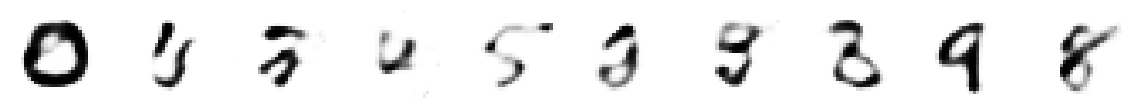

In [6]:
imgs = x_test
encoded_imgs = s_encoder.predict(imgs, batch_size=16)
codes = np.vstack([encoded_imgs.mean(axis=0)]*10)
np.fill_diagonal(codes, encoded_imgs.max(axis=0))

decoded_features = s_decoder.predict(codes, batch_size=16)
plot_digits(decoded_features)

Выше были коды, полученные из 8-ми часового обучения, на 15000 эпохах.  
На картинке ниже - полученные обучением в 400 эпох:   
![](pics/01_autoencoders_results_int_400.png)

Какие-то черты проглядываются, но ничего толкового тут не видно. При том видно, что количество эпох обучения сделали черты более выразтельными, но все равно особо репрезентативным назвать нельзя.    
Значения в кодах по одиночке никакого очевидного смысла не несут, лишь хитрое взаимодействие между значениями, происходящее в слоях декодера, позволяет ему по коду восстановить входной сигнал.